In [96]:
# import necessary modules
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from matplotlib import path
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import time
import xarray as xr
import rioxarray as rxr

In [ ]:
# Load ERA5 data
filename = r".\boundary_conditions\wave\raw\data_stream-wave.nc"
era5 = xr.open_dataset(filename)
era5=era5.sel(valid_time=slice('2019-03-13','2019-03-16')) # this is specific to the current model setup
era5.load()

<xarray.Dataset> Size: 296kB
Dimensions:     (valid_time: 96, latitude: 15, longitude: 17)
Coordinates:
    number      int64 8B 0
  * valid_time  (valid_time) datetime64[ns] 768B 2019-03-13 ... 2019-03-16T23...
  * latitude    (latitude) float64 120B -17.2 -17.7 -18.2 ... -23.2 -23.7 -24.2
  * longitude   (longitude) float64 136B 33.2 33.7 34.2 34.7 ... 40.2 40.7 41.2
    expver      (valid_time) <U4 2kB '0001' '0001' '0001' ... '0001' '0001'
Data variables:
    mwd         (valid_time, latitude, longitude) float32 98kB nan nan ... 161.2
    mwp         (valid_time, latitude, longitude) float32 98kB nan nan ... 8.377
    swh         (valid_time, latitude, longitude) float32 98kB nan nan ... 1.871
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-24T15:14 GRIB to CDM+CF via cfgrib-0.9.1...

In [146]:
# era5_notime = era5.isel(valid_time=0,drop=True)
# era5_notime.to_netcdf(".\\boundary_conditions\\wave\\raw\\data_stream-wave_notime.nc")

In [147]:
# Load GEBCO data
# GEBCO_dir = r"C:\Intern\SFINCS_Sofala\boundary_conditions\GEBCO_MZB\gebco_2024_n-13.0_s-25.0_w30.0_e45.0.nc"
# gebco_ds = xr.open_dataset(GEBCO_dir)
# gebco_lon, gebco_lat = np.meshgrid(gebco_ds['lon'].values, gebco_ds['lat'].values)
# gebco_depth = gebco_ds['elevation'].values

In [148]:
# Load bounding box from GeoPackage
#bbox_filepath = r"C:\Intern\SFINCS_Sofala\boundary_conditions\Quadtree_Mask\final_bbox.gpkg"
bbox_filepath = r".\boundary_conditions\gis\bbox_new.gpkg"
bbox_gdf = gpd.read_file(bbox_filepath)

In [149]:
# Copy ERA5 dataset and rename variables to fit SFINCS expectations
era5new = era5.copy()
if "time" not in era5new.coords:
    era5new = era5new.rename({"valid_time": "time"})

era5new = era5new.rename({
    "swh": "hs",
    "mwp": "tp",
    "mwd": "wd",
    "longitude": "lon",
    "latitude": "lat"
})
era5new = era5new.set_coords(["lon", "lat"])

In [ ]:
# write crs
era5new = era5new.rio.write_crs('EPSG:4326')
era5new = era5new.rio.reproject('EPSG:32736')

In [151]:
era5new = era5new.rename({
    "x": "lon",
    "y": "lat"})

In [ ]:
# Add directional spreading (ds) if missing
era5new = era5new.assign(ds=30.0 * xr.ones_like(era5new["hs"]))

# Convert longitude coordinates from [0, 360] to [-180, 180]
era5new["lon"] = xr.where(era5new["lon"] > 180, era5new["lon"] - 360, era5new["lon"])


# Filter points within the bounding box
lon_flat, lat_flat = np.meshgrid(era5new["lon"], era5new["lat"])
points_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(lon_flat.ravel(), lat_flat.ravel()),
    crs="EPSG:4326"
)

bbox_gdf = bbox_gdf.to_crs('EPSG:32736')
points_within_bbox = points_gdf[points_gdf.within(bbox_gdf.unary_union)]
era5new = era5new.sel(
    lon=xr.DataArray(points_within_bbox.geometry.x.values, dims="index"),
    lat=xr.DataArray(points_within_bbox.geometry.y.values, dims="index"),
    method="nearest"
)

C:\Users\aleksand\AppData\Local\Temp\ipykernel_21092\1252484166.py:16: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  points_within_bbox = points_gdf[points_gdf.within(bbox_gdf.unary_union)]


In [ ]:
# drop values with NaNs - you should end up only with the offshore points that are part of your bounding box
era5new = era5new.dropna(dim='index')

In [153]:


# # Interpolate GEBCO depth at ERA5 points
# interpolator = RegularGridInterpolator(
#     (gebco_ds['lat'].values, gebco_ds['lon'].values), 
#     gebco_depth, bounds_error=False, fill_value=np.nan
# )
# depth_values = interpolator((points_within_bbox.geometry.y, points_within_bbox.geometry.x))

# # Filter points where GEBCO depth is less than -5 m
# points_within_bbox["depth"] = depth_values
# valid_points = points_within_bbox[points_within_bbox["depth"] < -5]

# # Filter ERA5 dataset to only include valid points based on bounding box and depth

# # Filter points where hs is non-zero across the entire time dimension
# hs_mean = era5new["hs"].mean(dim="time")
# non_zero_hs_points = hs_mean != 0  # Identify points with non-zero hs over time

# # Filter out points where tp is outside the range 2 - 45 s
# tp_min, tp_max = 2, 45
# tp_mean = era5new["tp"].mean(dim="time")
# valid_tp_points = (tp_mean >= tp_min) & (tp_mean <= tp_max)

# # Combine hs and tp filters
# valid_points = non_zero_hs_points & valid_tp_points

# # Apply the combined filters to the dataset
# era5new = era5new.isel(index=valid_points)

# # Ensure the time coordinate is a valid datetime format if necessary
# if not np.issubdtype(era5new.coords["time"].dtype, np.datetime64):
#     era5new["time"] = xr.cftime_range(start="2019-03-01", periods=len(era5new["time"]), freq="1H")

In [ ]:
# Set CRS attribute for the dataset and fill NaN values
era5new.attrs["crs"] = "EPSG:32736"
era5new = era5new.fillna(0)

era5new = era5new.rename({"lon": "x"})
era5new = era5new.rename({"lat": "y"})

# Save the filtered dataset as a 1D point NetCDF file
#output_path = r"C:\Intern\SFINCS_Sofala\boundary_conditions\wave\ERA5_whole\era5_wave_final.nc"
output_path = r".\boundary_conditions\wave\era5_wave_new.nc"
era5new.to_netcdf(output_path)

print(f"Filtered dataset saved to: {output_path}")

Filtered dataset saved to: .\boundary_conditions\wave\era5_wave_new3.nc


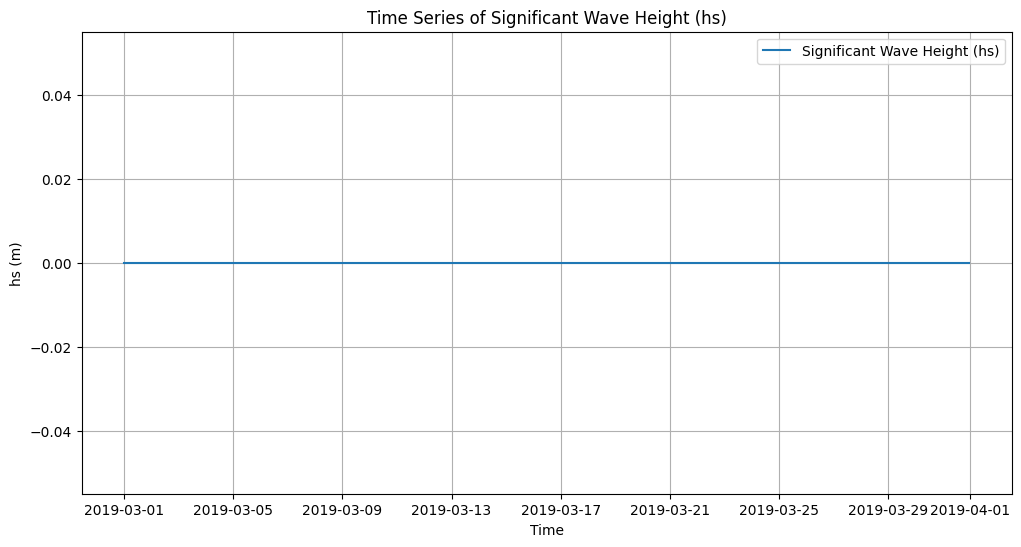

In [18]:
# Select the location(s) where you want to plot the time series
# Here, I'll select the first point for demonstration (Turns out it is the only point haha)
hs_data = era5new["hs"].isel(index=0)  # Change 'points=0' to select other points if needed

# Plot the time series of hs
plt.figure(figsize=(12, 6))
plt.plot(hs_data["time"], hs_data, label="Significant Wave Height (hs)")
plt.xlabel("Time")
plt.ylabel("hs (m)")
plt.title("Time Series of Significant Wave Height (hs)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# filepath = r"C:\Intern\SFINCS_Sofala\IWS_final_2\snapwave.nc"
# snapwave = xr.open_dataset(filepath)

# snapwave.load()

<xarray.Dataset> Size: 4kB
Dimensions:      (time: 73, index: 3)
Coordinates:
  * time         (time) datetime64[ns] 584B 2019-03-13 ... 2019-03-16
  * index        (index) int64 24B 0 1 2
    spatial_ref  int32 4B 0
    x            (index) float64 24B 7.155e+05 7.33e+05 7.795e+05
    y            (index) float64 24B 7.728e+06 7.77e+06 7.808e+06
Data variables:
    hs           (index, time) float32 876B 1.957 1.982 1.999 ... 1.812 1.761
    tp           (index, time) float32 876B 7.253 7.318 7.4 ... 5.715 5.709
    wd           (index, time) float32 876B 130.1 130.4 130.4 ... 105.1 105.1
    ds           (index, time) float32 876B 30.0 30.0 30.0 ... 30.0 30.0 30.0

In [ ]:
# filepath = r"C:\Intern\SFINCS_Sofala\Tim_SFINCS_waves\test_duck3\snapwave.nc"
# snapwave = xr.open_dataset(filepath)

# snapwave.load()

<xarray.Dataset> Size: 188B
Dimensions:      (time: 2, index: 2)
Coordinates:
  * time         (time) datetime64[ns] 16B 1990-10-13T16:00:00 1990-10-14T19:...
  * index        (index) int32 8B 1 2
    spatial_ref  int32 4B 0
    x            (index) float64 16B 0.0 0.0
    y            (index) float64 16B 0.0 2.1e+03
Data variables:
    hs           (index, time) float64 32B 1.81 1.81 1.81 1.81
    tp           (index, time) float64 32B 10.6 10.6 10.6 10.6
    wd           (index, time) float64 32B 286.0 286.0 286.0 286.0
    ds           (index, time) float64 32B 30.6 30.6 30.6 30.6